# __Black Pearl Coffee Shop Sales__

### <u>_Afridoyo Siringo-ringo_</u>

## __Description__

### Background

Black Pearl is a newly opened coffee shop with a pirate theme that operate in three locations: X, Y, and Z. The company offers a variety of coffee, tea, and drinking chocolate products. This project analyzes sales data from each location for the first semester of 2023 to provide insights into customer behavior and preferences, with the goal of supporting business growth and development.

### Objective
To derive insights that can help Black Pearl coffee shop optimize sales and improve product offerings.

### About The Data

The dataset contains transactional data for Black Pearl coffee shop and includes the following columns:
- ```transaction_id``` : Unique identifier for each transaction.
- ```transaction_date``` : Date of the transaction.
- ```transaction_time``` : Time of the transaction.
- ```transaction_qty``` : Quantity of items purchased.
- ```store_id``` and ```store_location``` : Identifier and location of the store where the transaction occurred.
- ```product_id``` : Identifier for the product.
- ```unit_price``` : Price per unit of the product.
- ```product_category``` : Category of the product.
- ```product_type``` : Type of the product.
- ```product_detail``` : Detailed description of the product.

### Problem Statement

- What are the best-selling products and categories?
- Are there seasonal or time-based trends in sales?
- How do sales compare across the three locations?

## __Import Libraries__


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# SQL query
import duckdb as db

# Seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Holt-Winters forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Regression error metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [2]:
# Suppressing Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# SQL function
def sql(sql_query):
    return db.sql(sql_query).to_df()

## __Load Data__

In [4]:
sales = pd.read_excel("Black_Pearl_Sales.xlsx")
sales.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,X,32,3.0,Coffee,Gourmet brewed coffee,Cthulu Blend Rg
1,2,2023-01-01,07:08:56,2,5,X,57,3.1,Tea,Brewed Chai tea,OctoChai Latte Lg
2,3,2023-01-01,07:14:04,2,5,X,59,4.5,Drinking Chocolate,Hot chocolate,Jolly Roaster's Dark Chocolate Lg
3,4,2023-01-01,07:20:24,1,5,X,22,2.0,Coffee,Drip coffee,Coral Reef Blend Sm
4,5,2023-01-01,07:22:41,2,5,X,57,3.1,Tea,Brewed Chai tea,OctoChai Latte Lg


## __Data Preparation and Exploration__

###  Duplicate Data and Missing Data

We will check whether there is duplicate data or missing data.

In [5]:
print(f"Duplicate Data: {sales.duplicated().sum()}")

Duplicate Data: 0


In [6]:
print(sales.isna().sum())

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


There are no duplicate data or missing data. The dataset is ready for the next analysis.

### Information about the structure and contents of the DataFrame

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


### Convert Data Type

In [8]:
sales['transaction_time'] = pd.to_datetime(sales['transaction_time'], format='%H:%M:%S')

### Adding new columns

In [11]:
# Revenue
sales["revenue"] = sales["transaction_qty"] * sales["unit_price"]

# The hour of the transactions
sales["transaction_hour"] = sales["transaction_time"].dt.hour

# Name of the day
sales["day_of_week"] = sales["transaction_date"].dt.day_name()

## __Sales Analysis__

In [12]:
# Data snippet
sales.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,revenue,transaction_hour,day_of_week
0,1,2023-01-01,1900-01-01 07:06:11,2,5,X,32,3.0,Coffee,Gourmet brewed coffee,Cthulu Blend Rg,6.0,7,Sunday
1,2,2023-01-01,1900-01-01 07:08:56,2,5,X,57,3.1,Tea,Brewed Chai tea,OctoChai Latte Lg,6.2,7,Sunday
2,3,2023-01-01,1900-01-01 07:14:04,2,5,X,59,4.5,Drinking Chocolate,Hot chocolate,Jolly Roaster's Dark Chocolate Lg,9.0,7,Sunday
3,4,2023-01-01,1900-01-01 07:20:24,1,5,X,22,2.0,Coffee,Drip coffee,Coral Reef Blend Sm,2.0,7,Sunday
4,5,2023-01-01,1900-01-01 07:22:41,2,5,X,57,3.1,Tea,Brewed Chai tea,OctoChai Latte Lg,6.2,7,Sunday


### Time Range

In [13]:
print(f'The time range of the data is : {sales['transaction_date'].min()} - {sales['transaction_date'].max()}')

The time range of the data is : 2023-01-01 00:00:00 - 2023-06-30 00:00:00


### Performance Summary

In [14]:
print(
    f"""
    Total Sales: ${round(sales["revenue"].sum()):,}
    Total Items Sold: {sales["transaction_qty"].sum():,}
    Average Order Size: ${round((sales["revenue"].mean()), 2)}
    Total of Menu Items: {sales["product_detail"].nunique()}
    Number of Stores: {sales["store_location"].nunique()}
    """
)


    Total Sales: $698,812
    Total Items Sold: 214,470
    Average Order Size: $4.69
    Total of Menu Items: 79
    Number of Stores: 3
    


Black Pearl has achieved a total sales of $698,812 with a total of 214,470 items sold in the first semester of 2023. The average total purchase per transaction $4.69. It has three coffee shops in three different locations that have 79 different menus.

### Top 10 Best Selling Items

In [17]:
# Query
best_selling = sql(
    """
    SELECT 
        product_detail,
        SUM(transaction_qty) as total_sold
    FROM sales
    GROUP BY product_detail
    ORDER BY SUM(transaction_qty) DESC
    LIMIT 10
    """
)

# Data viz with horizontal bar chart
fig = px.bar(
    best_selling, 
    x="total_sold", 
    y="product_detail", 
    orientation='h',
    color="product_detail",
    hover_name="product_detail"
)

# Custom layout
fig.update_layout(
    width=1200,
    title=dict(
        text='<span style="font-family:\'Times New Roman\';font-size:32;color:#008000">Top 10 Best Selling Items</span>',
        x=0.5
    ),
    xaxis_title="Total Units Sold",
    yaxis_title="",
    showlegend=False
)

fig.show()

The best-selling item is Earl Grey Rg, with a total of 4,708 units sold, making it the most popular choice among buyers. Note that the difference in the number of units sold for each product is only slight.

### 10 Top Earner Items

In [18]:
# Query
top_earner = sql(
    """
    SELECT 
        product_detail,
        SUM(revenue) as total_revenue
    FROM sales
    GROUP BY product_detail
    ORDER BY SUM(revenue) DESC
    LIMIT 10
    """
)

# Data viz with horizontal bar chart
fig = px.bar(
    top_earner, 
    x="total_revenue", 
    y="product_detail", 
    orientation='h',
    color="product_detail",
    hover_name="product_detail"
)

# Custom layout
fig.update_layout(
    width=1200,
    title=dict(
        text='<span style="font-family:\'Times New Roman\';font-size:32;color:#008000">10 Top Earner Items</span>',
        x=0.5
    ),
    xaxis_title="Total Sales ($)",
    yaxis_title="",
    xaxis=dict(tickformat=","),
    showlegend=False
)

fig.show()

The top earner is Davy Jones Hot Chocolate Lg, generating total sales of $21,151.75, making it the highest revenue-generating item based on sales, followed by Jolly Roaster's Dark Chocolate Lg with a slight difference with a value of $21,006.

### Total Sales by Product Category

In [19]:
# Query
sales_by_category = sql(
    """
    SELECT 
        product_category,
        SUM(revenue) AS total_sales
    FROM sales
    GROUP BY product_category
    ORDER BY SUM(revenue) DESC
    """
)

# Data viz with horizontal bar chart
fig = px.bar(
    sales_by_category, 
    x="total_sales", 
    y="product_category", 
    orientation='h',
    color="product_category",
    hover_name="product_category"
)

# Custome layout
fig.update_layout(
    width=1200,
    title=dict(
        text='<span style="font-family:\'Times New Roman\';font-size:32;color:#008000">Total Sales by Product Category</span>',
        x=0.5
    ),
    xaxis_title="Total Sales ($)",
    yaxis_title="",
    xaxis=dict(tickformat=","),
    showlegend=False
)

fig.show()

The coffee product category generated a revenue of $269,952.45, making it the top earner. This figure makes sense, as the shop primarily focuses on coffee. The sales reflect the demand for coffee among customers, aligning with the shop's core offerings.

### Total Sales By Locations

In [72]:
sales_by_locations = sql(
    """
    SELECT
        store_location,
        SUM(revenue) AS total_sales
    FROM sales
    GROUP BY store_location
    """
)

sales_by_locations

,store_location,total_sales
0,Y,236511.17
1,Z,232243.91
2,X,230057.25


In [73]:
# Data viz with horizontal bar chart
fig = px.bar(
    sales_by_locations, 
    x="store_location", 
    y="total_sales", 
    color="store_location",
    hover_name="store_location"
)

# Custome layout
fig.update_layout(
    width=1200,
    title=dict(
        text='<span style="font-family:\'Times New Roman\';font-size:32;color:#008000">Total Sales by Store Locations</span>',
        x=0.5
    ),
    xaxis_title="Total Sales ($)",
    yaxis_title="",
    xaxis=dict(tickformat=","),
    showlegend=False
)

fig.show()

The location Y has generated the highest revenue. However, it's important to note that the financial performance across all three locations is relatively similar, as the differences in total sales among them are not substantial.

## __Distribution of Total Sales Per Hour: Peak Sales Times__

Here we will analyze at what time Kraken Koffee shop generates the highest and lowest revenue.

In [20]:
# Query
hourly_rev = sql(
    """
    SELECT 
        DAYOFWEEK(transaction_date) AS day,
        day_of_week,
        transaction_hour,
        SUM(revenue) AS total_sales
    FROM sales
    GROUP BY 
        DAYOFWEEK(transaction_date),
        day_of_week,
        transaction_hour
    ORDER BY 
        DAYOFWEEK(transaction_date),
        transaction_hour
    """
)
hourly_rev.head()

,day,day_of_week,transaction_hour,total_sales
0,0,Sunday,6,3320.73
1,0,Sunday,7,8892.09
2,0,Sunday,8,11615.54
3,0,Sunday,9,12388.75
4,0,Sunday,10,12382.75


We will use pivot table to transform the table

In [21]:
pivot_df = hourly_rev.pivot(index="day_of_week", columns="transaction_hour", values="total_sales")
pivot_df

transaction_hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_of_week,,,,,,,,,,,,,,,
Friday,3385.73,9386.04,11746.65,12750.00,13155.66,6827.84,5685.49,5499.49,5840.33,6098.13,5654.93,5687.14,5139.84,4128.20,387.53
Monday,3098.58,9516.52,11604.69,11898.33,12427.25,7179.09,6139.64,5771.26,6463.31,6159.49,6139.96,5927.35,5006.19,4015.22,330.40
Saturday,2913.85,8775.02,11370.86,11333.85,12736.48,6361.41,5957.75,5549.45,5626.89,5946.50,5825.73,5444.70,4642.40,3970.96,438.63
Sunday,3320.73,8892.09,11615.54,12388.75,12382.75,6118.99,5622.99,5908.18,5765.62,5614.75,5728.46,5788.39,4792.48,4006.71,383.88
Thursday,3464.90,9209.23,11420.49,10963.73,12091.09,6898.55,6073.93,5972.46,6114.61,6087.68,6400.13,6027.33,5234.58,4529.10,279.97
Tuesday,2320.25,8841.71,12950.19,13588.47,13497.68,5877.41,5172.64,5443.46,5621.56,5852.24,5723.78,5609.85,4304.36,3967.94,684.40
Wednesday,3396.23,8905.86,11991.45,12246.40,12382.48,7055.85,5540.35,6223.15,5872.42,5974.31,5649.76,5649.55,5166.35,3828.55,430.83


In [49]:
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Sort the names of the days
pivot_df = pivot_df.reindex(days_order)
pivot_df

transaction_hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_of_week,,,,,,,,,,,,,,,
Monday,3098.58,9516.52,11604.69,11898.33,12427.25,7179.09,6139.64,5771.26,6463.31,6159.49,6139.96,5927.35,5006.19,4015.22,330.40
Tuesday,2320.25,8841.71,12950.19,13588.47,13497.68,5877.41,5172.64,5443.46,5621.56,5852.24,5723.78,5609.85,4304.36,3967.94,684.40
Wednesday,3396.23,8905.86,11991.45,12246.40,12382.48,7055.85,5540.35,6223.15,5872.42,5974.31,5649.76,5649.55,5166.35,3828.55,430.83
Thursday,3464.90,9209.23,11420.49,10963.73,12091.09,6898.55,6073.93,5972.46,6114.61,6087.68,6400.13,6027.33,5234.58,4529.10,279.97
Friday,3385.73,9386.04,11746.65,12750.00,13155.66,6827.84,5685.49,5499.49,5840.33,6098.13,5654.93,5687.14,5139.84,4128.20,387.53
Saturday,2913.85,8775.02,11370.86,11333.85,12736.48,6361.41,5957.75,5549.45,5626.89,5946.50,5825.73,5444.70,4642.40,3970.96,438.63
Sunday,3320.73,8892.09,11615.54,12388.75,12382.75,6118.99,5622.99,5908.18,5765.62,5614.75,5728.46,5788.39,4792.48,4006.71,383.88


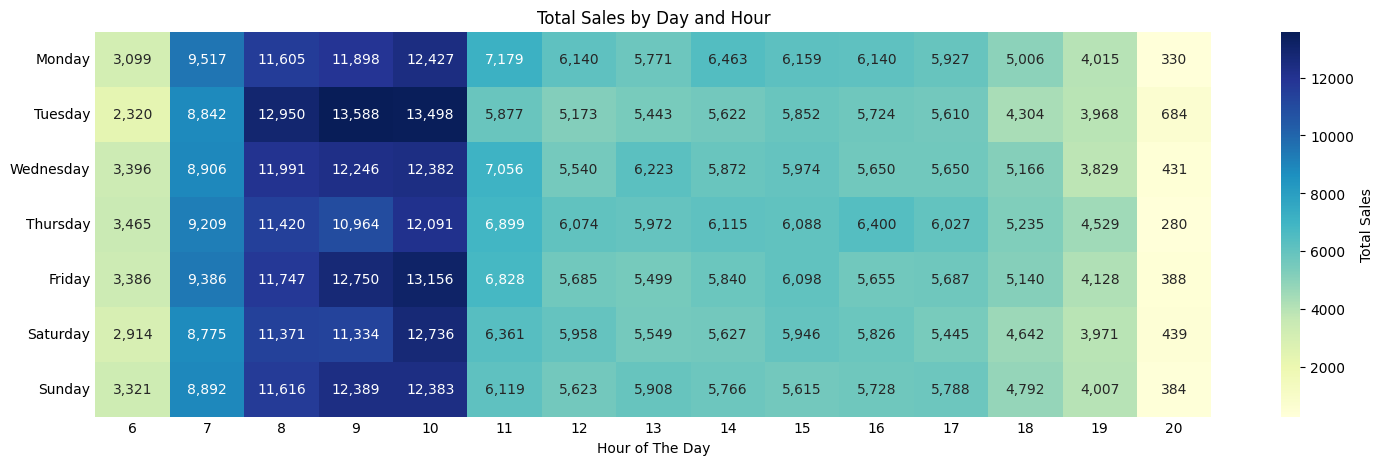

In [50]:
# Data viz with heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(pivot_df, annot=True, fmt=',.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Sales'})
plt.title('Total Sales by Day and Hour')
plt.xlabel('Hour of The Day')
plt.ylabel('')
plt.tick_params(axis='both', which='both', length=0)
plt.show()

In [48]:
print(f'Average sales at 20.00 to 21.00 is ${pivot_df.loc[:, 20].mean():.2f}')
print(f'Total sales at 20.00 to 21.00 is ${pivot_df.loc[:, 20].sum():,.2f}')

Average sales at 20.00 to 21.00 is $419.38
Total sales at 20.00 to 21.00 is $2,935.64


From this heatmap we can see a few key insights:
- Black Pearl Coffee Shop is always open every day of the week.
- Sales tend to peak around 7 AM to 11 AM. This suggests high customer traffic during typical breakfast hours. 
- There's a noticeable decline in sales at 8 PM, which are significantly lower than during peak hours, with an average of $419.38 and a total of $2,935.64.

Recommendation: 

Due to the low revenue at 8 PM, it might be a good idea to close the coffee shop at this time instead of staying open later. This could cut down on costs like staff wages and utilities when there aren't enough sales to cover them. Additionally, adjusting the hours could help manage staff better and improve service during the busier times, which might increase profits.

## __Time Series Analysis: Sales Projection__

In [23]:
# Query
sales_trend = sql(
    """
    SELECT 
        transaction_date,
        SUM(revenue) as sales
    FROM sales
    GROUP BY transaction_date
    ORDER BY transaction_date ASC
    """
)

sales_trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  181 non-null    datetime64[ns]
 1   sales             181 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [24]:
# Make a time series data frame
sales_trend = sales_trend.set_index('transaction_date')
sales_trend.head()

,sales
transaction_date,
2023-01-01,2508.20
2023-01-02,2403.35
2023-01-03,2565.00
2023-01-04,2220.10
2023-01-05,2418.85


In [25]:
# Set the frequency to daily
sales_trend = sales_trend.asfreq('D')

In [26]:
# Confirm the changes
sales_trend.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-24',
               '2023-06-25', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='transaction_date', length=181, freq='D')

In [27]:
# Data viz of sales trend
fig = px.line(sales_trend, x=sales_trend.index, y="sales")
fig.update_layout(
    width=1200,
    height=600,
    title=dict(
        text='<span style="font-family:\'Times New Roman\';font-size:32;color:#008000">Sales Trend in The First Semester of 2023</span>',
        x=0.5
    )
)

fig.show()

At first glance it appears that sales have an upward trend and have seasonality. Next we will decompose this time series to see this pattern better.

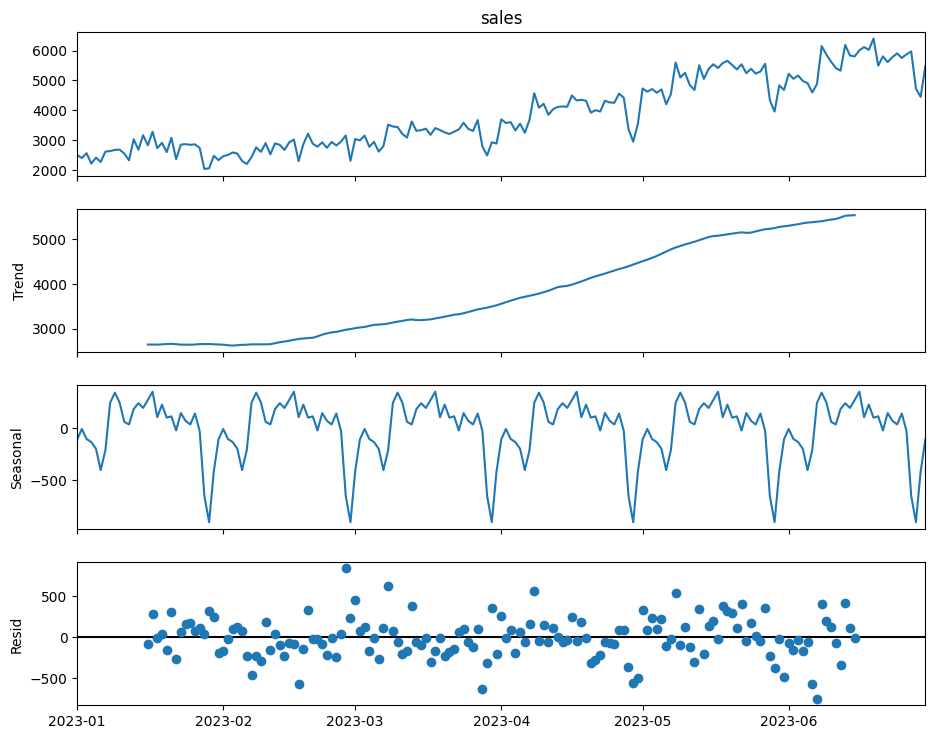

In [28]:
# Seasonal decompose
decomposition = seasonal_decompose(
    sales_trend['sales'],
    model='add',
    period=30
)

fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

__Observation results__ :
- We can see that sales have an upward trend. This trend shows a slow but consistent increase in sales over time. This indicates that, overall, there was growth in sales during this period, despite daily fluctuations.
- Sales have a seasonality component where sales will drop quite drastically at the end of each month and increase slightly at the beginning of the month.  

### Sales Forecasting

In this segment we will forecast sales in the second semester of 2023 using the Holt-Winters method.

In [29]:
# split train test data
train, test = sales_trend.iloc[:-30, 0], sales_trend.iloc[-30:, 0]

### Holt-Winters Model

In [32]:
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='mul',
    seasonal_periods=30
).fit()

In [33]:
predictions = model.forecast(steps=len(test))
predictions.head()

2023-06-01    5318.633475
2023-06-02    5305.891789
2023-06-03    5147.366785
2023-06-04    5215.302809
2023-06-05    4846.571905
Freq: D, dtype: float64

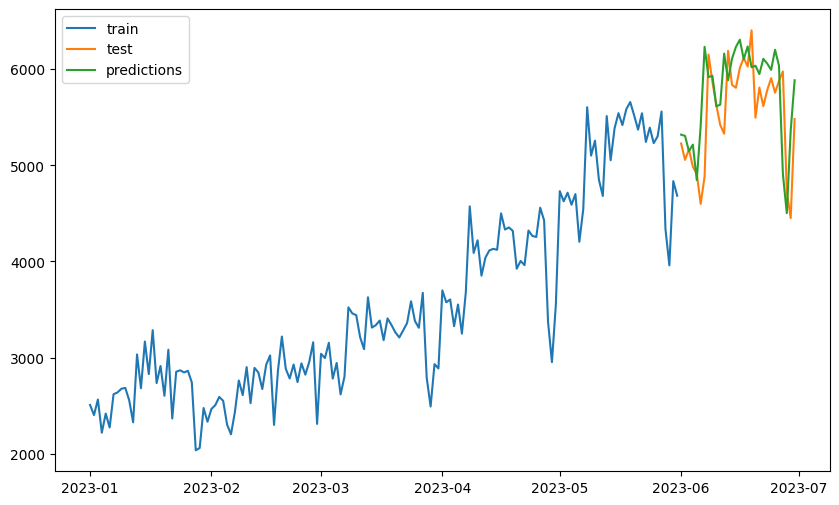

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

### Model Evaluation

In [37]:
# Calculate MAE, RMSE, MAPE
mae = mean_absolute_error(test, predictions)
rmse =  root_mean_squared_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)

print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 360.68
The RMSE is 485.40
The MAPE is 6.75 %


### Predicting Sales in the 2nd semester of 2023

In [57]:
model = ExponentialSmoothing(
    sales_trend['sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=30
).fit()

predictions = model.forecast(184)


In [58]:
predictions

2023-07-01    5827.448477
2023-07-02    5755.359575
2023-07-03    5676.523982
2023-07-04    5656.509492
2023-07-05    5363.855652
                 ...     
2023-12-27    9378.020274
2023-12-28    9765.370197
2023-12-29    9630.020720
2023-12-30    9483.870868
2023-12-31    9436.347823
Freq: D, Length: 184, dtype: float64

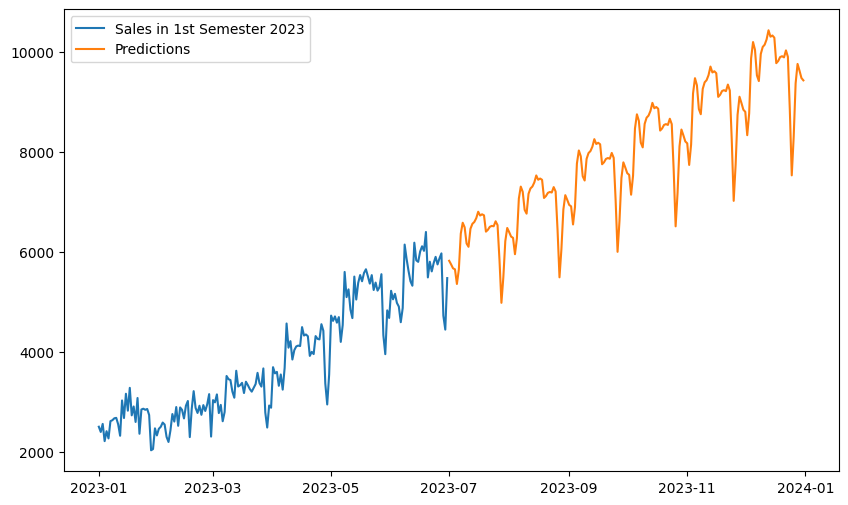

In [59]:
plt.figure(figsize=(10,6))

plt.plot(sales_trend['sales'], label='Sales in 1st Semester 2023')
plt.plot(predictions, label='Predictions')

plt.legend()
plt.show()

In [61]:
increase_in_sales = ((predictions.sum() - sales_trend['sales'].sum())/sales_trend['sales'].sum()) * 100
print(f'sales increase by {increase_in_sales:.2f}% in the second semester of 2023')

sales increase by 109.09% in the second semester of 2023


From the analysis of the sales prediction graph using the Holt-Winters model, it appears there is a consistent upward trend in sales data. Based on predictions, sales will increase by 109.09% in the next semester.

Recomendation:

-   Since sales are going up, plan promotions and marketing efforts to keep customers interested and engaged. Tailor promotions around observed peak times and customer preferences gathered from sales data.
-  Prepare for potential high-traffic periods by optimizing staffing and inventory based on forecasted sales peaks.

__The results of this forecast show an optimistic upward trend, but the following points need to be noted:__
- The steady increase in sales might be due to initial interest as the coffee shop is new. This kind of trend is common with new establishments as they attract initial curiosity and visits from potential regulars.
-  With only six months of data, predicting long-term trends can be unreliable. Early data from new businesses might not fully capture cyclical trends or the effect of external factors like seasonality and market competition.
-  The model might be overly optimistic due to the short amount of data available. This can cause it to not accurately predict future changes, such as potential decreases in sales once the initial excitement of the coffee shop's opening fades.


## __Recomendation__

__Business Strategy Adjustments:__

- __Promotional Activities:__ Plan promotions and marketing efforts to keep customers interested and engaged. Tailor promotions around observed peak times and customer preferences
- __Operational Planning:__ Prepare for potential high-traffic periods by optimizing staffing and inventory based on forecasted sales peaks.
- __Early Close__ Due to the low revenue at 8 PM, it might be a good idea to close the coffee shop at this time instead of staying open later.

__Data Collection:__

-  __Data Duration:__ Aim to collect at least one to two years of data. This duration will help capture a wider range of seasonal variations and customer behavior patterns.
- __Diversify Data Sources:__ Start incorporating data on local events, weather conditions, and economic indicators which might influence customer purchasing behavior.
- __Customer Feedback:__ Regularly gather customer feedback to understand preferences and dissatisfaction points, which can be crucial for adjusting business strategies.